# 🔵 **Dependencies**




In [1]:
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 5.1 MB/s eta 0:00:00


In [2]:
#for windows
!pip install -q soundfile
#for linux
!pip install -q sox

In [3]:
!pip install -q librosa

In [4]:
!pip install -q einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 832.4 kB/s eta 0:00:00


# 🔵 **Imports**

In [5]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split, Dataset
import torch.nn.functional as F

import torchaudio
from torchaudio import datasets
from torchaudio import transforms as T
from torchaudio import models
from torchaudio import pipelines

from torch.nn.utils.rnn import pad_sequence

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from torchvision import models as extractor


import numpy  as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
import torchmetrics as tm
import tqdm
import librosa
from collections import Counter

from IPython.display import Audio

In [6]:
!python --version

Python 3.10.12


In [7]:
for lib in [np, torch, torchaudio, torchtext, pd, tm, librosa]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.23.5
torch --> 2.1.0+cu118
torchaudio --> 2.1.0+cu118
torchtext --> 0.16.0+cpu
pandas --> 1.5.3
torchmetrics --> 1.2.1
librosa --> 0.10.1


# 🔵 **Utils**

In [8]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [9]:
def to_sentence(preds, inputs):
  sentences_preds = []
  for pred in preds:
    indexes = pred.argmax(dim = -1).tolist()
    sentence = [ch_vocab.get_itos()[index] for index in indexes]
    sentence = ''.join(sentence).replace('<sos>', '')
    sentence = sentence.replace('<eos>', '')
    sentence = sentence.replace('<pad>', '')
    sentences_preds.append(''.join(sentence))

  sentences_inputs = []
  for input in inputs:
    indexes = input.tolist()
    sentence = [ch_vocab.get_itos()[index] for index in indexes]
    sentence = ''.join(sentence).replace('<sos>', '')
    sentence = sentence.replace('<eos>', '')
    sentence = sentence.replace('<pad>', '')
    sentences_inputs.append(sentence)

  return sentences_preds, sentences_inputs

In [10]:
import torch
from torch import nn
import torch.nn.functional as F
from einops import rearrange


class CTCLoss(nn.Module):
    """Convenient wrapper for CTCLoss that handles log_softmax and taking input/target lengths."""

    def __init__(self, blank: int = 0) -> None:
        """Init method.

        Args:
            blank (int, optional): Blank token. Defaults to 0.
        """
        super().__init__()
        self.blank = blank

    def forward(self, preds: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """Forward method.

        Args:
            preds (torch.Tensor): Model predictions. Tensor of shape (batch, sequence_length, num_classes), or (N, T, C).
            targets (torch.Tensor): Target tensor of shape (batch, max_seq_length). max_seq_length may vary
                per batch.

        Returns:
            torch.Tensor: Loss scalar.
        """
        preds = preds.log_softmax(-1)
        batch, seq_len, classes = preds.shape
        preds = rearrange(preds, "n t c -> t n c") # since ctc_loss needs (T, N, C) inputs
        # equiv. to preds = preds.permute(1, 0, 2), if you don't use einops

        pred_lengths = torch.full(size=(batch,), fill_value=seq_len, dtype=torch.long)
        target_lengths = torch.count_nonzero(targets, axis=1)

        return F.ctc_loss(preds, targets, pred_lengths, pred_lengths, blank=self.blank, zero_infinity=True)

In [11]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [12]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [13]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)

In [14]:
def print_stats(waveform, sample_rate = None, src = None):
  if src:
    print("_" * 10)
    print("Source:", src)
    print("_" * 10)

  if sample_rate:
    print("Sample Rate: ", sample_rate)

  print('Shape: ', tuple(waveform.shape))
  print('DType: ', waveform.dtype)
  print(f" - Max:   {waveform.max().item():6.3f}")
  print(f" - Min:   {waveform.min().item():6.3f}")
  print(f" - Mean:   {waveform.mean().item():6.3f}")
  print(f" - Std Dev:   {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

In [15]:
def plot_waveform(waveform, sample_rate, title = 'Waveform', xlim = None, ylim = None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth = 1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channels {c + 1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)

    figure.suptitle(title)
    plt.show(block = False)

In [16]:
def plot_spectrogram(specgram, title = None, ylabel = 'freq_bin'):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(T.AmplitudeToDB()(specgram), origin = 'lower')
  fig.colorbar(im, ax = axs)
  plt.show(block = False)

# 🔵 **Dataset**

## 🔵 **LoadDataset**

In [17]:
dataset = datasets.LJSPEECH('/content/', 'https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2', download = True)

100%|██████████| 2.56G/2.56G [00:43<00:00, 63.1MB/s]


In [18]:
len(dataset)

13100

In [19]:
import csv
with open('/content/LJSpeech-1.1/metadata.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    file = []
    for row in spamreader:
        file.append(' '.join(row))

In [20]:
csv_dataset = []
for sen in file:
  sent = sen.split('|')
  csv_dataset.append([sent[0], sent[1]])

In [21]:
data_df = pd.DataFrame(csv_dataset, columns = ['id', 'text'])
data_df

,id,text
0,LJ001-0001,"Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...
...,...,...
13095,LJ050-0274,made certain recommendations which it believes...
13096,LJ050-0275,materially improve upon the procedures in effe...
13097,LJ050-0276,"As has been pointed out, the Commission has no..."
13098,LJ050-0277,with the active cooperation of the responsible...


In [22]:
class SplitData():
  def __init__(self, data_path):
    super(SplitData, self).__init__()
    data = np.loadtxt(data_path, dtype = str).tolist()
    self.ids = []
    for name in data:
      id = data_df[data_df['id'] == name].index.item()
      self.ids.append(id)

  def __call__(self, idx):
    return dataset[self.ids[idx]]

  def __len__(self):
    return len(self.ids)

In [23]:
train_set = SplitData('train.txt')
valid_set = SplitData('valid.txt')
test_set  = SplitData('test.txt')

In [24]:
len(train_set), len(valid_set), len(test_set)

(12500, 100, 500)

In [25]:
tokenizer = get_tokenizer('basic_english')

In [26]:
sentences = []
for i in range(len(train_set)):
  sentences.append(train_set(i)[2])

In [27]:
train_tokens = tokenizer(' '.join(sentences))
len(train_tokens)

238961

In [28]:
train_tokens[0:20]

['it',
 'has',
 'used',
 'other',
 'treasury',
 'law',
 'enforcement',
 'agents',
 'on',
 'special',
 'experiments',
 'in',
 'building',
 'and',
 'route',
 'surveys',
 'in',
 'places',
 'to',
 'which']

In [29]:
vocab  = build_vocab_from_iterator([train_tokens], min_freq = 0, specials = ['<unk>', '<pad>' ,'<sos>', '<eos>'])
vocab.set_default_index(vocab['<unk>'])
vocab_size = len(vocab.get_itos())
vocab_size

14420

In [30]:
token_list = vocab.get_itos()
characters = []
for token in token_list:
    chrc = list(token)
    for ch in chrc:
      characters.append(ch)

len(characters)

110573

In [31]:
ch_vocab  = build_vocab_from_iterator([characters], min_freq = 0, specials = ['<unk>', '<pad>' ,'<sos>', '<eos>', ' '])
ch_vocab.set_default_index(ch_vocab['<unk>'])
ch_vocab_size = len(ch_vocab.get_itos())
ch_vocab_size

65

## 🔵 **EDA**

In [ ]:
l_sentences = []
for sentence in sentences:
  l_sentences.append(len(tokenizer(sentence)))

In [ ]:
L_df = pd.DataFrame(l_sentences, index = sentences, columns = ['L'])
L_df

In [ ]:
L_df.describe()

In [ ]:
word_counts = Counter()
for word in train_tokens:
    word_counts.update([word])

In [ ]:
N_word = pd.DataFrame(word_counts.values(), index = word_counts.keys(), columns = ['N']).sort_values('N')
N_word.describe()

In [ ]:
plt.boxplot(N_word)
plt.show()

In [ ]:
N_word[N_word['N']>5000]

In [ ]:
N_word[N_word['N']<2]

In [ ]:
waveform, sample_rate, text, _  = train_set(0)

In [ ]:
print_stats(waveform, sample_rate)
plot_waveform(waveform, sample_rate)
mel_spectro = T.MelSpectrogram(sample_rate, n_fft = 1024, hop_length = 128, n_mels = 150)
spec = mel_spectro(waveform)

In [ ]:
plot_spectrogram(spec[0])

In [ ]:
text

In [ ]:
Audio(waveform.numpy(), rate = sample_rate)

In [ ]:
wav_info = []
for i in range(len(train_set)):
  sample, sample_rate, _, _  = train_set(i)
  wav_info.append([sample.shape[1]/sample_rate, sample.mean().item(), sample.std().item()])

In [ ]:
wav_df = pd.DataFrame(wav_info, columns = ['time', 'mean', 'std'])
wav_df.describe()

### average mean = 0.000009 ||| average std = 0.066083

## 🔵 **CustomDataset**




In [32]:
transform = nn.Sequential(T.MelSpectrogram(sample_rate = 22050, n_fft = 256, hop_length = 512, n_mels = 32),
                          T.FrequencyMasking(freq_mask_param = 5),
                          T.TimeMasking(time_mask_param = 10, p = 0.5))

In [33]:
class LJSpeechDataset(Dataset):
  def __init__(self, dataset, tokenizer, vocab, transform = None):
    super(LJSpeechDataset, self).__init__()
    self.dataset   = dataset
    self.tokenizer = tokenizer
    self.vocab     = vocab
    self.transform = transform

  def __getitem__(self, idx):
    wavform, sample_rate, text, _ = self.dataset(idx)

    if self.transform:
      input = self.transform(wavform)
    else:
      input = T.MelSpectrogram(sample_rate, n_fft = 256, hop_length = 512, n_mels = 32)(wavform)

    characters = list(text)
    characters.append('<eos>')
    characters.insert(0, '<sos>')
    text_idx = [self.vocab[character.lower()] for character in characters]
    target   = torch.LongTensor(text_idx)

    return input, target

  def __len__(self):
    return len(self.dataset)

In [34]:
train_dataset = LJSpeechDataset(train_set, tokenizer, ch_vocab, transform)
valid_dataset = LJSpeechDataset(valid_set, tokenizer, ch_vocab, None)
test_dataset  = LJSpeechDataset(test_set, tokenizer , ch_vocab, None)

In [35]:
spec, taregt = train_dataset[0]
spec.shape, taregt

(torch.Size([1, 32, 425]),
 tensor([ 2,  6, 11,  4, 20, 10,  7,  4, 16,  7,  5, 14,  4, 12, 11, 20,  5,  9,
          4, 11,  9,  5, 10,  7, 16,  9, 22,  4, 13, 10, 25,  4,  5,  8, 23, 12,
          9, 15,  5, 19,  5,  8, 11,  4, 10, 18,  5,  8, 11,  7,  4, 12,  8,  4,
          7, 17,  5, 15,  6, 10, 13,  4,  5, 28, 17,  5,  9,  6, 19,  5,  8, 11,
          7,  4,  6,  8,  4, 21, 16,  6, 13, 14,  6,  8, 18,  4, 10,  8, 14,  4,
          9, 12, 16, 11,  5,  4,  7, 16,  9, 24,  5, 22,  7,  4,  6,  8,  4, 17,
         13, 10, 15,  5,  7,  4, 11, 12,  4, 25, 20,  6, 15, 20,  4, 11, 20,  5,
          4, 17,  9,  5,  7,  6, 14,  5,  8, 11,  4, 23,  9,  5, 32, 16,  5,  8,
         11, 13, 22,  4, 11,  9, 10, 24,  5, 13,  7, 57,  3]))

## 🔵 **Visualize**

In [36]:
import random
def visualize_random_sample(n, dataset, vocab):

  n_random_idx = random.sample(range(0, len(dataset) - 1), n)

  audios = []
  texts  = []
  for idx in n_random_idx:

      spec, text_idx = dataset[idx]
      wavform = T.InverseMelScale(n_stft = 256, n_mels = 32, sample_rate = 22050)(spec[0])
      audios.append(Audio(wavform, rate = 22050))
      display(plot_spectrogram(spec[0]))
      #display(Audio(wavform, rate = 22050))


      text = [vocab.get_itos()[index] for index in text_idx.tolist()]
      texts.append(text)
      print(''.join(text))

  return audios, texts

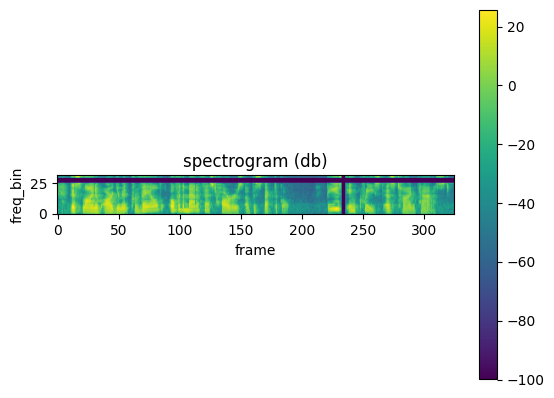

None

<sos>this line of argument prevailed over the manifest horrors of the spectacle. these increased as time passed.<eos>


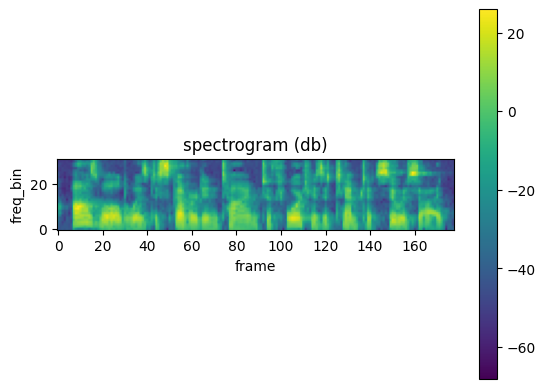

None

<sos>oswald was discovered in time to thwart his attempt at suicide.<eos>


In [37]:
audios, texts = visualize_random_sample(2, train_dataset, ch_vocab)

## 🔵 **DataLoader**

In [38]:
def collate_fn(batch):
  samples = [b[0][0].t() for b in batch]
  samples = pad_sequence(samples, batch_first = True, ).unsqueeze(1)
  targets  = [b[1] for b in batch]
  targets  = pad_sequence(targets, batch_first = True, padding_value = vocab['<pad>'])

  return samples, targets

In [39]:
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True, collate_fn = collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size = 16, shuffle = False, collate_fn = collate_fn)
test_loader  = DataLoader(test_dataset , batch_size = 16, shuffle = False, collate_fn = collate_fn)

In [40]:
input, target = next(iter(train_loader))

In [41]:
input.shape, target.shape

(torch.Size([16, 1, 430, 32]), torch.Size([16, 157]))

# 🔵 **Model**

In [42]:
import math
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [43]:
class Speech2Text(nn.Module):
  def __init__(self, num_encoder_layer, num_decoder_layer, nhead, dim_forward, dropout, batch_first,
               vocab_size, embedding_dim, c = 8, freq = 32):
    super(Speech2Text, self).__init__()

    self.d_model = int(c * 8 * freq / 8)
    #self.pos_encoder = PositionalEncoding(embedding_dim, dropout)

    self.feature_extractor = nn.Sequential(nn.Conv2d(1, c, (3, 3), stride = (1, 1), padding = (1, 1)),
                                           nn.BatchNorm2d(c),
                                           nn.ReLU(),
                                           nn.Conv2d(c, c * 2, (3, 3), stride = (1, 1), padding = (1, 1)),
                                           nn.BatchNorm2d(c * 2),
                                           nn.ReLU(),
                                           nn.MaxPool2d(2, 2),
                                           nn.Conv2d(c * 2, c * 4, (3, 3), stride = (1, 1), padding = (1, 1)),
                                           nn.BatchNorm2d(c * 4),
                                           nn.ReLU(),
                                           nn.MaxPool2d(2, 2),
                                           nn.Conv2d(c * 4, c * 8, (3, 3), stride = (1, 1), padding = (1, 1)),
                                           nn.BatchNorm2d(c * 8),
                                           nn.ReLU(),
                                           nn.MaxPool2d(2, 2))
    #self.fc = nn.Linear(int(c * 2 * freq / 4), self.d_model)

    self.transformer = nn.Transformer(self.d_model, nhead, num_encoder_layer, num_decoder_layer, dim_forward, dropout, batch_first = batch_first)

    self.embedding  = nn.Embedding(vocab_size, embedding_dim, 0)
    self.dim_change = nn.Linear(embedding_dim, self.d_model)

    self.cls_head = nn.Linear(self.d_model, vocab_size)

  #def init_weights(self) -> None:
  #      initrange = 0.1
  #      self.embedding.weight.data.uniform_(-initrange, initrange)
  #      self.fc.bias.data.zero_()
  #      self.fc.weight.data.uniform_(-initrange, initrange)

  def forward(self, audio, tokens):
    y = self.Encoder(audio)
    y = self.Decoder(y, tokens)
    return y

  def Encoder(self, audio):
    y = self.feature_extractor(audio)
    y = y.permute(0, 2, 1, 3)
    y = y.flatten(2)
    #y = self.fc(y)
    y = self.transformer.encoder(y)

    return y

  def Decoder(self, encoder_out, tokens):
    y = self.embedding(tokens) #* math.sqrt(self.d_model)
    y = self.dim_change(y)
    #y = self.pos_encoder(y)
    tgt_mask = self.transformer.generate_square_subsequent_mask(y.shape[1])
    y = self.transformer.decoder(y, encoder_out,tgt_mask = tgt_mask)
    y = self.cls_head(y)

    return y


In [44]:
model = Speech2Text(1, 1, 1, 10, 0.1, True, ch_vocab_size, 10).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [45]:
num_trainable_params(model)

0.848655

In [46]:
audio, tokens = next(iter(train_loader))

In [47]:
audio.shape, tokens.shape

(torch.Size([16, 1, 402, 32]), torch.Size([16, 150]))

In [48]:
model(audio.to(device), tokens[:, 0:-1].to(device)).shape

torch.Size([16, 149, 65])

# 🔵 **Config**


In [49]:
loss_func = nn.CrossEntropyLoss()
metric = tm.text.WordErrorRate().to(device)

# 🔵 **Train**

In [50]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, shedular, metric, epoch=None):
  model.train()
  loss_train = AverageMeter()
  metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for audios, tokens in tepoch:
      if epoch or epoch == 0:
        tepoch.set_description(f'Epoch {epoch}')


      audios  = audios.to(device)
      tokens   = tokens.to(device)

      outputs = model(audios, tokens[:, 0:-1])

      loss = loss_fn(outputs.permute(0, 2, 1), tokens[:, 1:])

      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
      optimizer.step()
      if shedular:
        shedular.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      #pred_sentences, input_sentences = to_sentence(outputs, tokens)
      #metric.update(pred_sentences, input_sentences)


      tepoch.set_postfix(loss=loss_train.avg, WER=metric.compute().item())

  return model, loss_train.avg, metric.compute().item()

# 🔵 **Evaluate**

In [51]:
def evaluate(model, data_loader, loss_fn, metric):
  model.eval()
  metric.reset()

  loss_valid = AverageMeter()

  for audios, tokens in data_loader:

    audios = audios.to(device)
    tokens = tokens.to(device)
    with torch.no_grad():
      outputs = model(audios, tokens[:, 0:-1])

    loss = loss_fn(outputs.permute(0, 2, 1), tokens[:, 1:])
    loss_valid.update(loss)
    pred_sentences, input_sentences = to_sentence(outputs, tokens)

    metric.update(pred_sentences, input_sentences)

  print(f'Loss : {loss_valid.avg.item()}, WER : {metric.compute().item()}')

  return loss_valid.avg.item(), metric.compute().item()

# 🔵 **Training Peocess**

## 🔵 **Step1**

In [ ]:
audios, tokens = next(iter(train_loader))
audios.shape, tokens.shape

(torch.Size([32, 1, 296, 20]), torch.Size([32, 167]))

In [ ]:
model = Speech2Text(1, 1, 1, 10, 0.1, True, ch_vocab_size, 10).to(device)
num_trainable_params(model)

0.141865

In [ ]:
loss_func = nn.CrossEntropyLoss(ignore_index = vocab['<pad>'])

In [ ]:
pred = model(audios.to(device), tokens[:, 0:-1].to(device))
pred.shape

torch.Size([32, 166, 65])

In [ ]:
pred.shape, tokens[:, 1:].shape

(torch.Size([32, 166, 65]), torch.Size([32, 166]))

In [ ]:
loss_func(pred.permute(0, 2, 1), tokens[:, 1:].to(device))

tensor(4.4652, device='cuda:0', grad_fn=<NllLoss2DBackward0>)

## 🔵 **Step2**

In [ ]:
torch.cuda.empty_cache()
model = Speech2Text(4, 1, 128, 512, 0.1, True, ch_vocab_size, 256, 16).to(device)
num_trainable_params(model)

9.222817

In [ ]:
#optimizer = optim.SGD(model.parameters(), lr = 0.1, momentum = 0.9)
optimizer = optim.Adam(model.parameters(), lr = 0.001, betas = [0.9, 0.99])
shedular  = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 1000, eta_min = 1e-6)
loss_func = nn.CrossEntropyLoss(ignore_index = vocab['<pad>'])
#loss_func = CTCLoss(blank = vocab['<pad>'])
metric    = tm.text.WordErrorRate().to(device)

In [ ]:
sub_set, _ = random_split(train_dataset, (10, len(train_dataset) - 10))
len(sub_set)

10

In [ ]:
sub_loader = DataLoader(sub_set, batch_size = 1, shuffle = True, collate_fn = collate_fn)

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, sub_loader, loss_func, optimizer, shedular, metric, epoch)

Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 19.96batch/s, WER=nan, loss=0.365]


## 🔵 **Step3**

In [ ]:
num_epochs = 5
lr_list    = [0.2, 0.1, 0.05, 0.01]
results    = []

for lr in lr_list:
  sub_result = []
  print(f'LR={lr}')

  model = Speech2Text2(1, 1024, 0.2, True, vocab_size, 1024, 8).to(device)

  optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9)
  loss_func = nn.CrossEntropyLoss(ignore_index = vocab['<pad>'])
  metric    = tm.text.WordErrorRate().to(device)

  for epoch in range(num_epochs):
    model, train_loss, _ = train_one_epoch(model, train_loader, loss_func, optimizer, None, metric, epoch)

    if epoch == 0:
      sub_result.append(train_loss)
    if epoch == 4:
      sub_result.append(train_loss)

  results.append(sub_result)

  print()

LR=0.2


Epoch 0:   0%|          | 0/98 [00:01<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric WordErrorRate was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
Epoch 4: 100%|██████████| 98/98 [04:11<00:00,  2.57s/batch, WER=nan, loss=4.64]



LR=0.1


Epoch 4: 100%|██████████| 98/98 [04:12<00:00,  2.58s/batch, WER=nan, loss=4.83]



LR=0.05


Epoch 4: 100%|██████████| 98/98 [04:09<00:00,  2.55s/batch, WER=nan, loss=5.07]



LR=0.01


Epoch 4: 100%|██████████| 98/98 [04:11<00:00,  2.57s/batch, WER=nan, loss=5.53]

In [ ]:
pd.DataFrame(results, columns = ['start', 'stop'], index = lr_list)

,start,stop
0.20,5.976154,4.643085
0.10,6.061775,4.830877
0.05,6.194632,5.070207
0.01,6.783027,5.534679


## 🔵 **Step4**

In [ ]:
lr_list = [0.2]
wd_list = [0, 1e-4,  1e-5, 1e-6]
result  = []
indexes = []

for lr in lr_list:
  for wd in wd_list:

    print(f'LR = {lr}, Weight_decay = {wd}')
    indexes.append(f'LR = {lr}, Weight_decay = {wd}')

    sub_result = []

    model = Speech2Text2(1, 1024, 0.2, True, vocab_size, 1024, 8).to(device)

    optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9, weight_decay = wd)
    loss_func = nn.CrossEntropyLoss(ignore_index = vocab['<pad>'])
    metric    = tm.text.WordErrorRate().to(device)

    for i in range(4):
      model, train_loss, metric_train = train_one_epoch(model, train_loader, loss_func, optimizer, None, metric, i)
      valid_loss, metric_valid        = evaluate(model, valid_loader, loss_func, metric)

      if i == 0:
        sub_result.append(train_loss)
        sub_result.append(valid_loss)
      if i == 3:
        sub_result.append(train_loss)
        sub_result.append(valid_loss)

    result.append(sub_result)
    torch.save(model, f'/content/models-step4/model*{lr}*{wd}.pt')
    print('model saved!')
    print('---------------------------------------------')

LR = 0.2, Weight_decay = 0


Epoch 0:   0%|          | 0/98 [00:01<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric WordErrorRate was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
Epoch 0: 100%|██████████| 98/98 [04:10<00:00,  2.56s/batch, WER=nan, loss=6.02]


Loss : 5.269885540008545, WER : 2.9978597164154053


Epoch 1: 100%|██████████| 98/98 [04:19<00:00,  2.65s/batch, WER=nan, loss=5.18]


Loss : 5.114354610443115, WER : 3.886035203933716


Epoch 2: 100%|██████████| 98/98 [04:11<00:00,  2.57s/batch, WER=nan, loss=4.95]


Loss : 5.007016658782959, WER : 3.804173469543457


Epoch 3: 100%|██████████| 98/98 [04:09<00:00,  2.55s/batch, WER=nan, loss=4.78]


Loss : 5.215822696685791, WER : 4.108614444732666
model saved!
---------------------------------------------
LR = 0.2, Weight_decay = 0.0001


Epoch 0: 100%|██████████| 98/98 [04:07<00:00,  2.53s/batch, WER=nan, loss=6.05]


Loss : 5.298216342926025, WER : 2.8897805213928223


Epoch 1: 100%|██████████| 98/98 [04:10<00:00,  2.55s/batch, WER=nan, loss=5.18]


Loss : 5.116942405700684, WER : 3.2129480838775635


Epoch 2: 100%|██████████| 98/98 [04:16<00:00,  2.61s/batch, WER=nan, loss=4.96]


Loss : 5.029481410980225, WER : 3.6597111225128174


Epoch 3: 100%|██████████| 98/98 [04:11<00:00,  2.57s/batch, WER=nan, loss=4.8]


Loss : 4.960768699645996, WER : 3.1246654987335205
model saved!
---------------------------------------------
LR = 0.2, Weight_decay = 1e-05


Epoch 0: 100%|██████████| 98/98 [04:17<00:00,  2.63s/batch, WER=nan, loss=6.14]


Loss : 5.327368259429932, WER : 3.7399678230285645


Epoch 1: 100%|██████████| 98/98 [04:29<00:00,  2.75s/batch, WER=nan, loss=5.2]


Loss : 5.129811763763428, WER : 3.3151416778564453


Epoch 2: 100%|██████████| 98/98 [04:20<00:00,  2.66s/batch, WER=nan, loss=4.97]


Loss : 5.024019241333008, WER : 3.4023542404174805


Epoch 3: 100%|██████████| 98/98 [04:21<00:00,  2.67s/batch, WER=nan, loss=4.8]


Loss : 6.086090564727783, WER : 3.2140181064605713
model saved!
---------------------------------------------
LR = 0.2, Weight_decay = 1e-06


Epoch 0: 100%|██████████| 98/98 [04:21<00:00,  2.67s/batch, WER=nan, loss=6.15]


Loss : 5.319130897521973, WER : 3.403959274291992


Epoch 1: 100%|██████████| 98/98 [04:22<00:00,  2.68s/batch, WER=nan, loss=5.18]


Loss : 5.099505424499512, WER : 3.203317165374756


Epoch 2: 100%|██████████| 98/98 [04:22<00:00,  2.68s/batch, WER=nan, loss=4.95]


Loss : 5.024977684020996, WER : 3.36543607711792


Epoch 3: 100%|██████████| 98/98 [04:22<00:00,  2.68s/batch, WER=nan, loss=4.79]


Loss : 5.008848667144775, WER : 3.688603639602661
model saved!
---------------------------------------------


In [ ]:
pd.DataFrame(result, index = indexes, columns = ['start train loss',
                                                 'start valid loss',
                                                 'stop train loss',
                                                 'stop valid loss'])

,start train loss,start valid loss,stop train loss,stop valid loss
"LR = 0.2, Weight_decay = 0",6.019434,5.269886,4.779911,5.215823
"LR = 0.2, Weight_decay = 0.0001",6.052258,5.298216,4.795388,4.960769
"LR = 0.2, Weight_decay = 1e-05",6.142838,5.327368,4.802420,6.086091
"LR = 0.2, Weight_decay = 1e-06",6.145826,5.319131,4.787834,5.008849


## 🔵 **Step5**

In [ ]:
model = torch.load('/content/models-step4/model*0.2*0.0001.pt').to(device)

In [ ]:
lr = 0.2
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9, weight_decay = wd)
loss_func = nn.CrossEntropyLoss(ignore_index = vocab['<pad>'])
metric    = tm.text.WordErrorRate().to(device)

In [ ]:
for i in range(5):
      model, train_loss, metric_train = train_one_epoch(model, train_loader, loss_func, optimizer, None, metric, i)
      valid_loss, metric_valid        = evaluate(model, valid_loader, loss_func, metric)

Epoch 0:   0%|          | 0/98 [00:02<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric WordErrorRate was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
Epoch 0: 100%|██████████| 98/98 [04:21<00:00,  2.67s/batch, WER=nan, loss=4.68]


Loss : 4.9659953117370605, WER : 3.2059924602508545


Epoch 1: 100%|██████████| 98/98 [04:24<00:00,  2.70s/batch, WER=nan, loss=4.57]


Loss : 4.936687469482422, WER : 3.5238094329833984


Epoch 2: 100%|██████████| 98/98 [04:21<00:00,  2.66s/batch, WER=nan, loss=4.47]


Loss : 6.866806983947754, WER : 2.460139036178589


Epoch 3: 100%|██████████| 98/98 [04:25<00:00,  2.71s/batch, WER=nan, loss=4.4]


Loss : 4.898231029510498, WER : 3.7003746032714844


Epoch 4: 100%|██████████| 98/98 [04:23<00:00,  2.69s/batch, WER=nan, loss=4.31]


Loss : 4.923610687255859, WER : 3.5976457595825195


## 🔵 **Main Loop**

In [ ]:
torch.cuda.empty_cache()

In [53]:
set_seed(42)
model = Speech2Text(2, 2, 64, 512, 0.1, True, ch_vocab_size, 256, 16).to(device)
num_trainable_params(model)

8.696481

In [54]:
set_seed(42)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, collate_fn = collate_fn)

In [55]:
train_loss_hist, valid_loss_hist = [], []
train_metric_hist, valid_metric_hist  =[], []
best_metric = torch.inf
best_loss   = torch.inf

In [56]:
lr = 0.6
wd = 1e-5
optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay = wd, momentum = 0.9)
shedular  = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 20000, eta_min = 1e-7)
loss_func = nn.CrossEntropyLoss(ignore_index = vocab['<pad>'])
#loss_func = nn.CTCLoss(blank = vocab['<pad>'])
#loss_func = CTCLoss(blank = vocab['<pad>'])
metric    = tm.text.WordErrorRate().to(device)

In [65]:
set_seed(42)

start, stop = 50, 60
wait = 0

for i in range(start, stop):

  model, train_loss, train_metric = train_one_epoch(model, train_loader, loss_func, optimizer, None, metric, i)
  valid_loss, valid_metric        = evaluate(model, valid_loader, loss_func, metric)

  train_loss_hist.append(train_loss)
  valid_loss_hist.append(valid_loss)
  train_metric_hist.append(train_metric)
  valid_metric_hist.append(valid_metric)

  if valid_loss<best_loss:

    torch.save(model, 'best_model.pt')
    print('model saved!')
    wait = 0
    best_loss = valid_loss

  else:
    wait += 1
    if wait >= 4 and i >= 0:
      lr = 0.5 * lr
      optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay = wd, momentum = 0.9)
      wait = 0

Epoch 50: 100%|██████████| 391/391 [03:39<00:00,  1.78batch/s, WER=nan, loss=0.773]


Loss : 1.1214783191680908, WER : 0.8200607895851135


Epoch 51: 100%|██████████| 391/391 [03:40<00:00,  1.77batch/s, WER=nan, loss=0.77]


Loss : 0.9888936877250671, WER : 0.8060790300369263


Epoch 52: 100%|██████████| 391/391 [03:40<00:00,  1.78batch/s, WER=nan, loss=0.772]


Loss : 0.9681597948074341, WER : 0.8012158274650574


Epoch 53: 100%|██████████| 391/391 [03:40<00:00,  1.78batch/s, WER=nan, loss=0.767]


Loss : 1.1664690971374512, WER : 0.8778115510940552


Epoch 54: 100%|██████████| 391/391 [03:41<00:00,  1.77batch/s, WER=nan, loss=0.763]


Loss : 0.795336902141571, WER : 0.7914893627166748


Epoch 55: 100%|██████████| 391/391 [03:40<00:00,  1.78batch/s, WER=nan, loss=0.764]


Loss : 1.3366609811782837, WER : 0.848024308681488


Epoch 56: 100%|██████████| 391/391 [03:40<00:00,  1.77batch/s, WER=nan, loss=0.759]


Loss : 0.8348811268806458, WER : 0.7805471420288086


Epoch 57: 100%|██████████| 391/391 [03:38<00:00,  1.79batch/s, WER=nan, loss=0.753]


Loss : 0.9151795506477356, WER : 0.7927051782608032


Epoch 58: 100%|██████████| 391/391 [03:38<00:00,  1.79batch/s, WER=nan, loss=0.753]


Loss : 1.0631660223007202, WER : 0.8042553067207336


Epoch 59: 100%|██████████| 391/391 [03:41<00:00,  1.77batch/s, WER=nan, loss=0.753]


Loss : 1.0918464660644531, WER : 0.8127659559249878


### 🔵 **Plot**

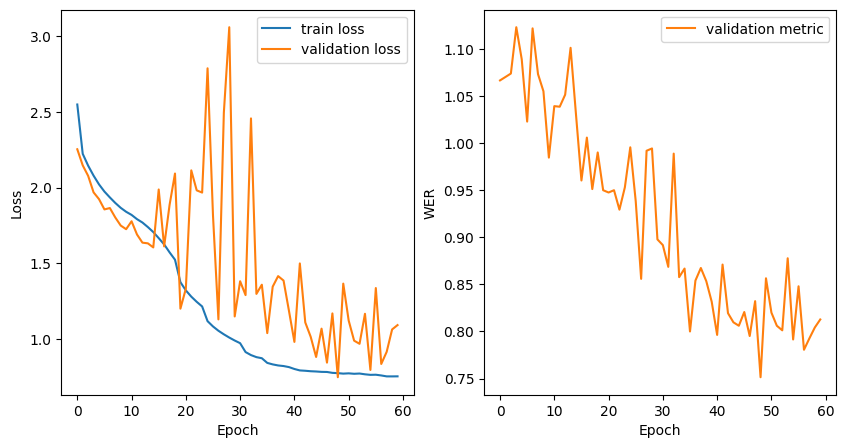

In [66]:
plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(stop), train_loss_hist, label = 'train loss')
plt.plot(range(stop), valid_loss_hist, label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_metric_hist)#, label = 'train metric')
plt.plot(valid_metric_hist, label = 'validation metric')
plt.xlabel('Epoch')
plt.ylabel('WER')
plt.legend()
plt.show()

# 🔵 **Test**

In [67]:
model = torch.load('best_model.pt').to(device).eval()

In [68]:
with torch.no_grad():
  _, _ = evaluate(model, test_loader, loss_func, metric)

Loss : 0.7471401691436768, WER : 0.7502376437187195


# 🔵 **Speech2Text**

In [69]:
model = torch.load('best_model.pt').to(device).eval()

In [70]:
def speech2text(model, wavform, sample_rate, vocab, real_text, metric):
  model.eval()

  input = T.MelSpectrogram(sample_rate, n_fft = 256, hop_length = 512, n_mels = 32)(wavform).unsqueeze(0).permute(0, 1, 3, 2)

  tokens = torch.LongTensor([vocab['<sos>']]).unsqueeze(0)
  end = False
  counter = 0
  while(end == False):

    with torch.no_grad():
      new_token = model(input.to(device), tokens.to(device))[:, -1, :]

    index = new_token.argmax(dim = -1)

    if index.item() == vocab['.'] or index.item() == vocab['<eos>']:
      tokens = torch.cat([tokens, torch.LongTensor([index.item()]).unsqueeze(0)], dim = -1)
      end = True

    elif counter == 200:
      end = True

    else:
      tokens = torch.cat([tokens, torch.LongTensor([index.item()]).unsqueeze(0)], dim = -1)
      counter += 1

  text = ''.join([vocab.get_itos()[idx] for idx in tokens.squeeze().tolist()])
  text = text.replace('<sos>', '')
  text = text.replace('<eos>', '')
  real_text = ' '.join(tokenizer(real_text))

  display(Audio(wavform, rate = sample_rate))
  display(text)
  print()
  display(real_text)
  print()
  display(metric([text], [real_text]))

In [71]:
idx_list = [3, 6, 9, 369, 333, 33, 36, 39]
for idx in idx_list:
  wavform, sample_rate, real_text, _ = test_set(idx)
  speech2text(model, wavform, sample_rate, ch_vocab, real_text, metric)

'the prisoner had been to the working to the old would have been to deparance, and bolth were the would the would the the boottaing to to the find to the selewars.'

'the prisoner had nothing to deal with but wooden panels , and by dint of cutting and chopping he got both the lower panels out .'

tensor(1., device='cuda:0')

'it is not possible that possible who certain to certain to certain to certain to certain to certain to certain to certain to certain to certain to certain to certain certaing.'

'it is not possible to state with scientific certainty that a particular small group of fibers come from a certain piece of clothing'

tensor(1.0870, device='cuda:0')

'j.'

'jeanne de mohrenschildt said , quote ,'

tensor(1., device='cuda:0')

'who had borned then cleased in the tendent, for a could hose corners.'

"who had borne the queen ' s commission , first as cornet , and then lieutenant , in the 10th hussars ."

tensor(0.9091, device='cuda:0')

'all want a such that rifle was not deay was not deay with the tendence such the tend the general hand and agents such the tenterns day was some day was some day hand tentemptent tempted.'

'all one had to do was get a high building someday with a telescopic rifle , and there was nothing anybody could do to defend against such an attempt .'

tensor(1.0667, device='cuda:0')

'to the valuaualuaurty twenty-pars in parlans.'

'to the value of £20 , 000 .'

tensor(0.7500, device='cuda:0')

'nor the debtory which the read was intered the met from those intered was intered greate was into times partrate and the metimes partratrate deained great great deat greatery.'

'nor did the methods by which they were perpetrated greatly vary from those in times past .'

tensor(1.4706, device='cuda:0')

'there on the same pin cinde cin condemned the same pin cinde cident out on the same perious sons the same the same peround the same ame the same the same same same same siles.'

'there among the ruins they still live in the same kind of houses ,'

tensor(2.2143, device='cuda:0')